<a href="https://colab.research.google.com/github/plaban1981/Generative_AI/blob/main/OpenAI_API_Function_Calls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Function Calls:

1. Create chatbots that answer questions by **calling external tools** (e.g., like ChatGPT Plugins)

2. Convert **natural language** into API calls or database queries

3. Extract **structured** data from text

### Example 1- Send Email

Email Anya to see if she wants to get coffee next Friday

`send_email(to: string, body: string)`

## Example 2 - Weather API

 What's the weather like in Bengaluru?

 `get_current_weather(location: string, unit: 'celsius' | 'fahrenheit')`


### Example 3 - Natural Language to Function/SQL

Who are my top ten customers this month?

`get_customers_by_revenue(start_date: string, end_date: string, limit: int)`

How many orders did Acme, Inc. place last month?

`sql_query(query: string)`

## Example 4 - Extract Structured Data

Extract details of the names mentioned in this Wikipedia article .....

`extract_people_data(people: [{name: string, birthday: string, location: string}])`

# Code Example

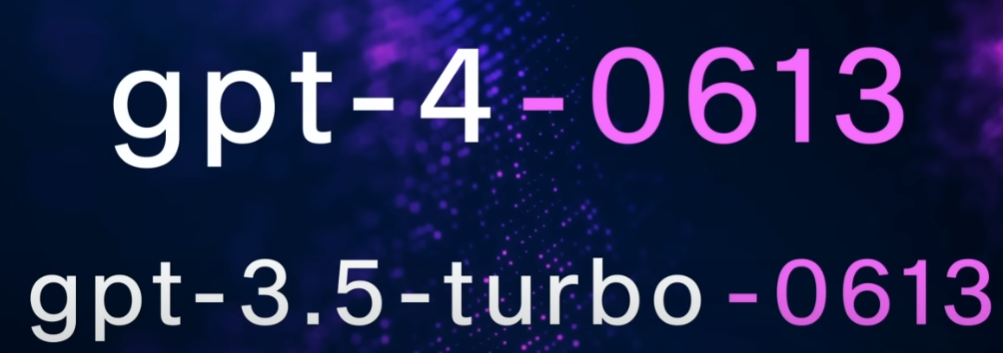

On the 13th June 2023 OpenAI released two new models, gpt-3.5-turbo-0613 and gpt-4-0613. Both models bring a new feature called **function calling to the API**.

**Function calling** allows us to
* describe code functions to the model, and
* the model will identify our intention and
* return a JSON object containing the arguments needed to call the function.
* the Model Completion API does not call the function instead the model generates a JSON that we can use to call the function in our code.

In [1]:
!pip install -qU \
  "openai==0.27.8" \
  "diffusers==0.17.1" \
  "transformers==4.30.2" \
  "accelerate==0.20.3" \
  "scipy==1.10.1" \
  "safetensors==0.3.1" \
  "xformers==0.0.20"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.1 MB/s eta 0:00:00


In [2]:
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt
from termcolor import colored
import requests

In [3]:
GPT_MODEL = "gpt-3.5-turbo-0613"


In [4]:
from getpass import getpass
openai.api_key = getpass()

··········


In [43]:
@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, functions=None, model=GPT_MODEL):
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + openai.api_key,
    }
    json_data = {"model": model, "messages": messages}
    if functions is not None:
        json_data.update({"functions": functions})
    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=json_data,
        )
        return response
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e

In [44]:
class Conversation:
    def __init__(self):
        self.conversation_history = []

    def add_message(self, role, content):
        message = {"role": role, "content": content}
        self.conversation_history.append(message)

    def display_conversation(self, detailed=False):
        role_to_color = {
            "system": "red",
            "user": "green",
            "assistant": "blue",
            "function": "magenta",
        }
        for message in self.conversation_history:
            print(
                colored(
                    f"{message['role']}: {message['content']}\n\n",
                    role_to_color[message["role"]],
                )
            )

Function Specification

In [45]:
functions = [
    {
        "name": "get_current_weather",
        "description": "Get the current weather",
        "parameters": {
            "type": "object",
            "properties": {
                "location": {
                    "type": "string",
                    "description": "The city and state, e.g. San Francisco, CA",
                },
                "format": {
                    "type": "string",
                    "enum": ["celsius", "fahrenheit"],
                    "description": "The temperature unit to use. Infer this from the users location.",
                },
            },
            "required": ["location", "format"],
        },
    }
]

In [46]:
conversation = Conversation()


In [47]:
conversation.add_message("user", "what is the weather like today in Bangalore")


In [ ]:
conversation

In [ ]:
#without function call
chat_response = chat_completion_request(
    conversation.conversation_history,
    functions = None
)
print(chat_response)

<Response [200]>


In [ ]:
chat_response.text

'{\n  "id": "chatcmpl-7S5HC2GyZc3gToCDObC6QyOfyZiPq",\n  "object": "chat.completion",\n  "created": 1686927822,\n  "model": "gpt-3.5-turbo-0613",\n  "choices": [\n    {\n      "index": 0,\n      "message": {\n        "role": "assistant",\n        "content": "I\'m sorry, but as an AI language model, I don\'t have real-time data. You can check the weather today in Bangalore by referring to a reliable weather website or using a weather application on your mobile device."\n      },\n      "finish_reason": "stop"\n    }\n  ],\n  "usage": {\n    "prompt_tokens": 15,\n    "completion_tokens": 44,\n    "total_tokens": 59\n  }\n}\n'

In [ ]:
type(chat_response.text)

str

In [ ]:
#with function call
chat_response = chat_completion_request(
    conversation.conversation_history,
    functions = functions
)

chat_response.json()

{'id': 'chatcmpl-7S5JJcnRPIBiuYujH6U08IS37xe7o',
 'object': 'chat.completion',
 'created': 1686927953,
 'model': 'gpt-3.5-turbo-0613',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': None,
    'function_call': {'name': 'get_current_weather',
     'arguments': '{\n  "location": "Bangalore",\n  "format": "celsius"\n}'}},
   'finish_reason': 'function_call'}],
 'usage': {'prompt_tokens': 92, 'completion_tokens': 25, 'total_tokens': 117}}

In [ ]:
import json
chat_response.json()['choices'][0]['message']

{'role': 'assistant',
 'content': None,
 'function_call': {'name': 'get_current_weather',
  'arguments': '{\n  "location": "Bangalore",\n  "format": "celsius"\n}'}}

In [ ]:
import json
json.loads(chat_response.json()['choices'][0]['message']['function_call']['arguments'])

{'location': 'Bangalore', 'format': 'celsius'}

In [ ]:
conversation.add_message("user", "what is the weather like today in Berlin")


In [ ]:
#with function call
chat_response = chat_completion_request(
    conversation.conversation_history,
    functions = functions
)

chat_response.json()

{'id': 'chatcmpl-7S5KiI9bmc5OT1ovUjG1VGNVUdKaz',
 'object': 'chat.completion',
 'created': 1686928040,
 'model': 'gpt-3.5-turbo-0613',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': None,
    'function_call': {'name': 'get_current_weather',
     'arguments': '{\n  "location": "Berlin",\n  "format": "celsius"\n}'}},
   'finish_reason': 'function_call'}],
 'usage': {'prompt_tokens': 104, 'completion_tokens': 24, 'total_tokens': 128}}

In [ ]:
import json
json.loads(chat_response.json()['choices'][0]['message']['function_call']['arguments'])

{'location': 'Berlin', 'format': 'celsius'}

In [ ]:
# confirm authentication was successful
openai.Engine.list()['data'][0]

<Engine engine id=whisper-1 at 0x7f72d6c276a0> JSON: {
  "object": "engine",
  "id": "whisper-1",
  "ready": true,
  "owner": "openai-internal",
  "permissions": null,
  "created": null
}

In [48]:
prompt = "What is the weather in Bangalore today ?"

res = openai.ChatCompletion.create(
    model='gpt-4-0613',  # swap for gpt-3.5-turbo-0613 if needed
    messages=[{"role": "user", "content": prompt}],
    functions=functions
)
res

<OpenAIObject chat.completion id=chatcmpl-7SSIsYzAQZOrHCWA7R74vIgc4mRDr at 0x7f4f8280d6c0> JSON: {
  "id": "chatcmpl-7SSIsYzAQZOrHCWA7R74vIgc4mRDr",
  "object": "chat.completion",
  "created": 1687016338,
  "model": "gpt-4-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": null,
        "function_call": {
          "name": "get_current_weather",
          "arguments": "{\n  \"location\": \"Bangalore\",\n  \"format\": \"celsius\"\n}"
        }
      },
      "finish_reason": "function_call"
    }
  ],
  "usage": {
    "prompt_tokens": 92,
    "completion_tokens": 25,
    "total_tokens": 117
  }
}

In [49]:
import json

name = res['choices'][0]['message']['function_call']['name']
args = json.loads(res['choices'][0]['message']['function_call']['arguments'])
name, args

('get_current_weather', {'location': 'Bangalore', 'format': 'celsius'})

##  Create a function that we will be using GPT-4 to call

In [30]:
from IPython.display import HTML

def page_builder(title: str, copy_text: str):
    """Takes title and copy text to create a product page in simple HTML
    """
    html = """<!DOCTYPE html>
<html>
  <head>
      <title>Awesome Product</title>
  </head>
  <body>
      <h1>"""+title+"""</h1>
      <p1>"""+copy_text+"""</p1>
  </body>
</html>"""
    with open('index.html', 'w') as fp:
        fp.write(html)
    return HTML(filename='index.html')

In [31]:
page_builder(
    title="Awesome Product",
    copy_text="Not very good copy text (it was written by a human)."
)

In [32]:
HTML("/content/index.html")

## Now let's ask GPT-4 to create the input to our function. We translate the function above into a function GPT-4 understands with:

In [8]:
page_builder_func = {
    "name": "page_builder",
    "description": "Creates product web pages",
    "parameters": {
        "type": "object",
        "properties": {
            "title": {
                "type": "string",
                "description": "The name of the product"
            },
            "copy_text": {
                "type": "string",
                "description": "Marketing copy that describes and sells the product"
            }
        },
        "required": ["title", "copy_text"]
    }
}

## Now we call the model using the typical format, but this time we add a new functions parameter that includes our func_str.

In [9]:
prompt = "Create a web page for a new cutting edge mango cutting machine"

res = openai.ChatCompletion.create(
    model='gpt-4-0613',  # swap for gpt-3.5-turbo-0613 if needed
    messages=[{"role": "user", "content": prompt}],
    functions=[page_builder_func]
)
res

<OpenAIObject chat.completion id=chatcmpl-7SRTHWpNto5KIiejtC8iaycDCGS12 at 0x7f4f827e6a20> JSON: {
  "id": "chatcmpl-7SRTHWpNto5KIiejtC8iaycDCGS12",
  "object": "chat.completion",
  "created": 1687013139,
  "model": "gpt-4-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": null,
        "function_call": {
          "name": "page_builder",
          "arguments": "{\n  \"title\": \"Cutting-Edge Mango Cutting Machine\", \n  \"copy_text\": \"Revolutionize your kitchen experience with our new Cutting-Edge Mango Cutting Machine! Crafted with precision and designed for efficiency, this state-of-the-art kitchen gadget will transform the way you handle mangoes. Its sharp, sturdy blades guarantee a clean, perfect cut every time, while its ergonomic design ensures optimal ease and comfort. Experience the future of kitchenware today with the Cutting-Edge Mango Cutting Machine!\"\n}"
        }
      },
      "finish_reason": "function_ca

## Now we can check to see if GPT-4 decided we should call a function:

In [10]:
if res['choices'][0]["finish_reason"] == "function_call":
    print("We should call a function!")

We should call a function!


In [11]:
import json

name = res['choices'][0]['message']['function_call']['name']
args = json.loads(res['choices'][0]['message']['function_call']['arguments'])
name, args

('page_builder',
 {'title': 'Cutting-Edge Mango Cutting Machine',
  'copy_text': 'Revolutionize your kitchen experience with our new Cutting-Edge Mango Cutting Machine! Crafted with precision and designed for efficiency, this state-of-the-art kitchen gadget will transform the way you handle mangoes. Its sharp, sturdy blades guarantee a clean, perfect cut every time, while its ergonomic design ensures optimal ease and comfort. Experience the future of kitchenware today with the Cutting-Edge Mango Cutting Machine!'})

In [12]:
prompt = "Create a web page for a Course Cirriculumn for Large Language Models"

res = openai.ChatCompletion.create(
    model='gpt-4-0613',  # swap for gpt-3.5-turbo-0613 if needed
    messages=[{"role": "user", "content": prompt}],
    functions=[page_builder_func]
)
res['choices'][0]['message']['function_call']['arguments']

'{\n  "title": "Course Curriculum for Large Language Models",\n  "copy_text": "Explore the possibilities of Artificial Intelligence with our specialized Curriculum for Large Language Models! This comprehensive course covers everything you need to know to master the concepts behind these sophisticated AI models. From the underlying theory to practical exercises, learn to leverage the innate potential of Large Language Models and stay ahead of the AI curve. Enroll today and start the path to mastering cutting-edge AI technology!"\n}'

In [14]:
args = json.loads(res['choices'][0]['message']['function_call']['arguments'])

In [33]:
page_builder(**args)

#### Nice, but we're missing something — maybe a interesting AI generated product image would be a good addition. For that we need a image generation model. Fortunately, we can initialize one easily using Hugging Face Diffusers like so:

cuda


  0%|          | 0/50 [00:00<?, ?it/s]

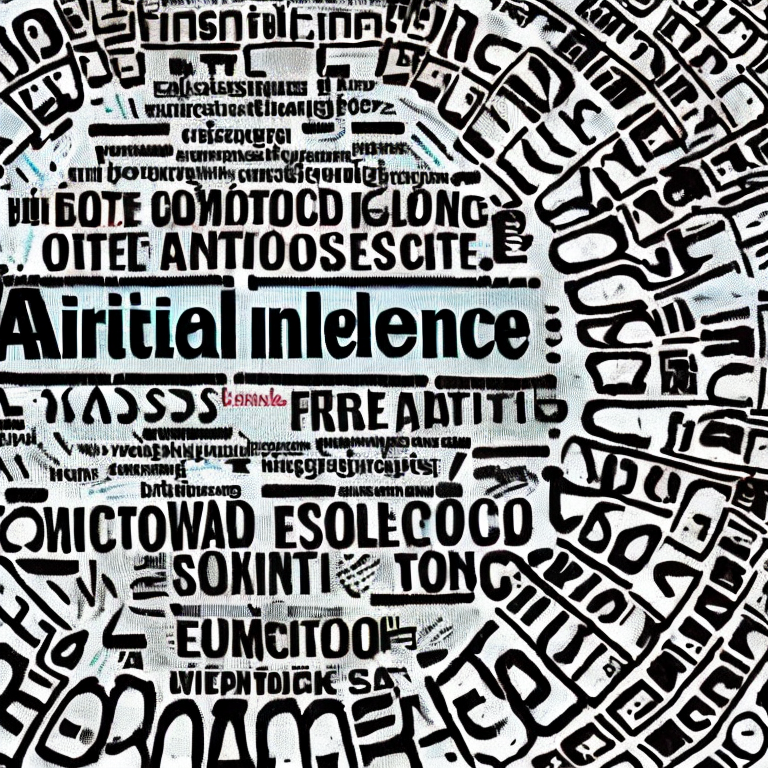

In [35]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

# use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model_id = "stabilityai/stable-diffusion-2-1"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

test_prompt = "a photo of Ariticial Intelligence "
image = pipe(test_prompt).images[0]

image.show()

#### Okay so we can generate images, now all we need to do is connect that functionality to our page_builder function, and update our function description so that GPT-4 knows how to use the image generation feature.

In [37]:
from IPython.display import HTML

def page_builder(title: str, copy_text: str, image_desc: str):
    """Takes title and copy text to create a product page in simple HTML
    """
    # generate the image and save
    image = pipe(image_desc).images[0]
    image.save("product.jpg")
    # generate html
    html = """<!DOCTYPE html>
<html>
  <head>
      <title>Awesome Product</title>
      <style>
        img {
          max-width: 50%;
          height: auto;
          margin-bottom: 20px;
        }
      </style>
  </head>
  <body>
      <img src="product.jpg">
      <h1>"""+title+"""</h1>
      <p1>"""+copy_text+"""</p1>
  </body>
</html>"""
    with open('index.html', 'w') as fp:
        fp.write(html)
    return HTML(filename='index.html')

In [38]:
page_builder_func = {
    "name": "page_builder",
    "description": "Creates product web pages",
    "parameters": {
        "type": "object",
        "properties": {
            "title": {
                "type": "string",
                "description": "The name of the product"
            },
            "copy_text": {
                "type": "string",
                "description": "Marketing copy that describes and sells the product"
            },
            "image_desc": {
                "type": "string",
                "description": "Concise description of the product image using descriptive language, no more than two sentences long"
            }
        },
        "required": ["title", "copy_text", "image_desc"]
    }
}

#### Run the function call wrapped into a single function

In [39]:
def query(prompt: str):
    res = openai.ChatCompletion.create(
        model='gpt-4-0613',  # swap for gpt-3.5-turbo-0613 if needed
        messages=[{"role": "user", "content": prompt}],
        functions=[page_builder_func]
    )
    if res['choices'][0]["finish_reason"] == "function_call":
        # this means we should call a function
        name = res['choices'][0]['message']['function_call']['name']
        args = json.loads(res['choices'][0]['message']['function_call']['arguments'])
        if name == 'page_builder':
            page_builder(**args)
        else:
            raise ValueError(f"Function name `{name}` not recognized!")
        return HTML('index.html')

In [40]:
query(prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

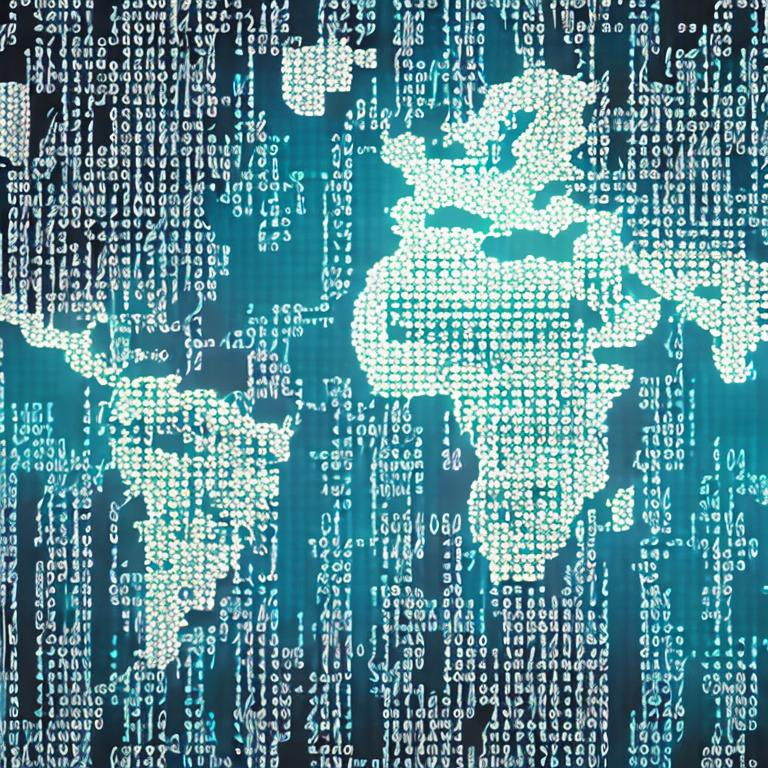

In [42]:
from IPython.display import Image
Image("/content/product.jpg")